# Single record IDA
#### Author: Orlando Arroyo
#### email: odarroyo@uc.cl

## Loading libraries

In [1]:
from openseespy.opensees import *
import opsvis as opsv # load opsvis for model visualization
import matplotlib.pyplot as plt # the standard plotting library
import opseestools.analisis as an # loading the 2D analysis module of opseestools 
import opseestools.utilidades as ut # loading the third module (utilidades) of opseestools
import numpy as np # loading numpy library

## Create the model of tutorial  as a Python function in terms of the analysis factor

In [2]:
def model1(analysis_factor):
    wipe() 
    model('basic','-ndm',2,'-ndf',3)
    x1 = 6.0
    x2 = 10.0
    y1 = 4.0
    y2 = 7.0

    node(1,0.0,0.0)
    node(2,x1,0.0)
    node(3,x2,0.0)
    node(4,0.0,y1)
    node(5,x1,y1)
    node(6,x2,y1)
    node(7,0.0,y2)
    node(8,x1,y2)
    node(9,x2,y2)

    # supports
    empotrado = [1,1,1] # fix all degrees
    grado2 = [1,1,0] # 

    fix(1,*empotrado)
    fix(2,*empotrado)
    fix(3,*empotrado)
    
    # diaphragms
    equalDOF(4,5,1) 
    equalDOF(4,6,1)
    equalDOF(7,8,1) 
    equalDOF(7,9,1)

    # massess
    mass(4,1,1,0) 
    mass(5,1,1,0)
    mass(6,1,1,0)
    mass(7,1,1,0)
    mass(8,1,1,0)
    mass(9,1,1,0)
    E = 24000000.0
    fc = 28000.0
    ec = 2*fc/E
    fcu = 0.2*fc
    ecu = 0.006

    # Para el concreto confinado
    k=1.3
    fcc=28000.0*k
    ecc= 2*fcc/E
    fucc=0.2*fcc
    eucc=0.02

    # Para el acero
    Fy=420000.0
    Es=210000000.0

    uniaxialMaterial('Concrete01', 2, fc, ec, fcu, ecu)
    uniaxialMaterial('Concrete01', 1, fcc, ecc, fucc, eucc)
    uniaxialMaterial('Steel01', 3, Fy, Es, 0.01)
    # Fiber section
    # 30 x 30 cm with 8 # 4

    Bcol = 0.3
    Hcol = 0.3
    c = 0.05  # recubrimiento 

    # creación de la sección de fibra
    y1col = Hcol/2.0
    z1col = Bcol/2.0

    y2col = 0.5*(Hcol-2*c)/3.0

    nFibZ = 1
    nFibZcore= 10
    nFib = 20
    nFibCover, nFibCore = 8, 16
    As4 = 0.000127
    As5 = 0.0002
    As7 = 0.000387

    sec30x30 = 1 # column section

    # Use of the BuildRCSection command 
    ut.BuildRCSection(sec30x30, Hcol, Bcol, c, c, 1, 2, 3, 3, As4, 3, As4, 4, As4, nFibCore, nFibZcore, nFibCover, nFibCover)

    # Five integration points with a Gauss-Lobatto integration scheme
    pint = 5 
    beamIntegration('Lobatto', sec30x30, sec30x30,pint) # integration scheme
    
    # Transformation
    lineal = 1
    geomTransf('Linear',lineal) # transformación lineal

    pdelta = 2
    geomTransf('PDelta',pdelta) # PDelta

    # Columns
    element('forceBeamColumn',1, 1,4 ,pdelta,sec30x30)
    element('forceBeamColumn',2, 4,7 ,pdelta,sec30x30)
    element('forceBeamColumn',3, 2,5 ,pdelta,sec30x30)
    element('forceBeamColumn',4, 5,8 ,pdelta,sec30x30)
    element('forceBeamColumn',5, 3,6 ,pdelta,sec30x30) 
    element('forceBeamColumn',6, 6,9 ,pdelta,sec30x30) 

    # Beams(for the example use the same section)
    element('forceBeamColumn',7, 4,5 ,lineal,sec30x30)
    element('forceBeamColumn',8, 5,6 ,lineal,sec30x30)
    element('forceBeamColumn',9, 7,8 ,lineal,sec30x30) 
    element('forceBeamColumn',10, 8,9 ,lineal,sec30x30)
    
    # loads
    timeSeries('Linear', 1)
    pattern('Plain',1,1)
    vigas = [7,8,9,10] 
    wviga = 20
    eleLoad('-ele',*vigas,'-type','beamUniform',-wviga)
    
    an.gravedad()
    loadConst('-time',0.0)
    time,techo,Eds,node_disp,node_vel,node_acel,drift = an.dinamicoIDA4P('GM01.txt',0.01,3000,0.01,9.81*analysis_factor,0.03,9,1,[1,3,5],[3,6,9])
    wipe()
    return time,drift
    
    
    

### Example of the function

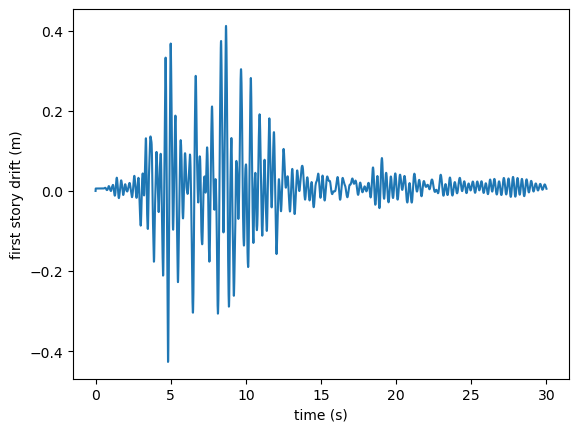

In [3]:
afactor = 1.0 # factor for the analysis
time1,drift1 = model1(afactor)
plt.plot(time1,drift1[:,0]*100)
plt.xlabel('time (s)')
plt.ylabel('first story drift (m)')
plt.show()

### IDA using a loop and extracting the maximum drift at the first floor

In [ ]:
# A few factors to run several time the analysis
afactors = [0.25,0.5,1.0,1.5,2.5,4.0]

maxdrift = []

for fact in afactors:
    time2,drift2 = model1(fact) # running the model with the factor
    drift_max_1F = np.max(np.abs(drift2[:,0]))*100 # for computing the maximum drift at the first floor in %
    maxdrift.append(drift_max_1F) # appending the results



#### Plotting the IDA

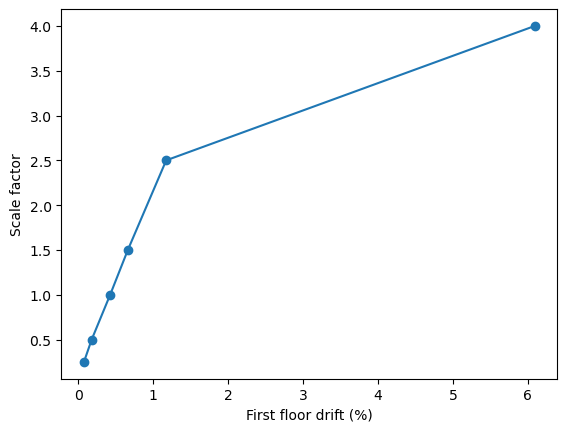

In [5]:
# Plotting IDA

plt.plot(maxdrift,afactors,'o-')
plt.xlabel('First floor drift (%)')
plt.ylabel('Scale factor')
plt.show()